In [1]:
import sys
import os

# Adjust the path to point to the 'src' directory relative to your notebook
sys.path.append(os.path.abspath("../src"))

import generations
import search_space
import data_preprocessing as dp

In [2]:
DATA_ID = 41143
X_train, y_train, X_val, y_val, X_test, y_test = dp.get_preprocessed_data(
        dataset_id=DATA_ID, scaling=True, random_seed=13, return_as='tensor')

Categorical features detected: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V44', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V57', 'V58', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V127', 'V128', 'V129', 'V130', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V139', 'V140', 'V141', 'V142'

In [3]:
len(X_train)

1909

In [4]:
input_size, output_size = dp.get_tensor_sizes(X_train, y_train)

In [5]:
search_space = search_space.SearchSpace(input_size=input_size, output_size=output_size)

In [6]:
N_INDIVIDUALS = 500 # amount of architectures to be evaluated as a starting point
N_EPOCHS = 10
percentile_drop = 25 # drop the worst 25% of architectures after each epoch

In [7]:
# The generation is created given the search space and the number of individuals.
generation = generations.Generation(search_space, N_INDIVIDUALS)

In [8]:
generation.run_ebe(epochs=N_EPOCHS,
                    X_train=X_train,
                    y_train=y_train,
                    X_val=X_val,
                    y_val=y_val, 
                    percentile_drop=percentile_drop)

Epoch 1/10 - Running EBE
Epoch 2/10 - Running EBE
Epoch 3/10 - Running EBE
Epoch 4/10 - Running EBE
Epoch 5/10 - Running EBE
Epoch 6/10 - Running EBE
Epoch 7/10 - Running EBE
Epoch 8/10 - Running EBE
Only 8 models left, stopping EBE.


In [9]:
results_df = generation.return_df()
display(results_df)

,hidden_layers,activation_fn,dropout_rate,optimizer_type,learning_rate,weight_decay,momentum,batch_size,use_skip_connections,initializer,...,scheduler_params,train_loss,train_acc,val_loss,val_acc,efforts,n_instances,fcst_accuracy,final_val_acc,final_val_loss
0,"[30, 394, 390]",<class 'torch.nn.modules.activation.Tanh'>,0.3,<class 'torch.optim.rmsprop.RMSprop'>,0.000664,0.000000,NaN,256,True,xavier_uniform,...,{'T_max': 100},"[0.7191141247749329, 0.6200900077819824, 0.545...","[0.49, 0.72, 0.7075, 0.745, 0.7525, 0.76794133...","[0.5760526061058044, 0.45864391326904297, 0.50...","[0.76, 0.78, 0.7475, 0.7635983263598326, 0.765...","[0.0, 0.10476689366160294, 0.41906757464641176...","[100, 200, 400, 800, 1600, 1909, 1909, 1909]",0.777386,0.767782,0.453169
1,"[424, 9]",<class 'torch.nn.modules.activation.ReLU'>,0.1,<class 'torch.optim.adam.Adam'>,0.029804,0.010000,NaN,64,True,kaiming_uniform,...,{'gamma': 0.95},"[0.8633534908294678, 0.7775647914409638, 0.543...","[0.57, 0.67, 0.7525, 0.78125, 0.76, 0.75013095...","[0.5863537979125977, 0.48738951206207276, 0.49...","[0.71, 0.78, 0.7525, 0.7698744769874477, 0.765...","[0.0, 0.10476689366160294, 0.41906757464641176...","[100, 200, 400, 800, 1600, 1909, 1909, 1909]",0.775939,0.765690,0.447372
2,"[320, 346, 384, 398, 155, 75, 186, 93]",<class 'torch.nn.modules.activation.Tanh'>,0.0,<class 'torch.optim.rmsprop.RMSprop'>,0.000586,0.000010,NaN,1024,False,kaiming_normal,...,"{'step_size': 5, 'gamma': 0.5}","[0.7865167856216431, 0.5756274461746216, 0.614...","[0.42, 0.69, 0.795, 0.765, 0.784375, 0.8166579...","[0.5787445902824402, 0.6522456407546997, 0.629...","[0.71, 0.76, 0.695, 0.7531380753138075, 0.7635...","[0.0, 0.10476689366160294, 0.41906757464641176...","[100, 200, 400, 800, 1600, 1909, 1909, 1909]",0.759994,0.761506,0.542998
3,"[352, 125, 261, 65, 443, 420, 296, 200, 195, 218]",<class 'torch.nn.modules.activation.Tanh'>,0.3,<class 'torch.optim.rmsprop.RMSprop'>,0.000262,0.000001,NaN,32,True,xavier_uniform,...,{'gamma': 0.99},"[0.6673952031135559, 0.6225685882568359, 0.554...","[0.61, 0.675, 0.73, 0.75125, 0.78875, 0.784180...","[0.5772476410865783, 0.7208246564865113, 0.547...","[0.72, 0.71, 0.7775, 0.7573221757322176, 0.765...","[0.0, 0.10476689366160294, 0.41906757464641176...","[100, 200, 400, 800, 1600, 1909, 1909, 1909]",0.768559,0.746862,0.596331
4,"[303, 66, 334, 226, 21, 134, 337, 325, 7, 188,...",<class 'torch.nn.modules.activation.Tanh'>,0.0,<class 'torch.optim.adam.Adam'>,0.000521,0.000100,NaN,512,False,kaiming_normal,...,{'gamma': 0.9},"[0.6796330213546753, 0.6883092522621155, 0.583...","[0.55, 0.615, 0.7075, 0.75375, 0.78125, 0.7983...","[0.5891554355621338, 0.5771584510803223, 0.558...","[0.71, 0.745, 0.7475, 0.7405857740585774, 0.74...","[0.0, 0.10476689366160294, 0.41906757464641176...","[100, 200, 400, 800, 1600, 1909, 1909, 1909]",0.760932,0.725941,0.519410
5,"[6, 485]",<class 'torch.nn.modules.activation.LeakyReLU'>,0.5,<class 'torch.optim.adam.Adam'>,0.000216,0.001000,NaN,32,False,kaiming_normal,...,{'T_max': 10},"[0.9371836757659913, 0.7407075309753418, 0.852...","[0.4, 0.5, 0.4875, 0.47625, 0.520625, 0.555264...","[0.6639646553993225, 0.6672019672393799, 0.671...","[0.62, 0.58, 0.6125, 0.6255230125523012, 0.640...","[0.0, 0.10476689366160294, 0.41906757464641176...","[100, 200, 400, 800, 1600, 1909, 1909, 1909]",0.672597,0.723849,0.540166
6,"[208, 454, 279, 408, 394, 347, 285, 349, 200, ...",<class 'torch.nn.modules.activation.ReLU'>,0.5,<class 'torch.optim.adamw.AdamW'>,0.033782,0.000000,NaN,64,True,kaiming_normal,...,{'T_max': 50},"[8224679399.135, 830.6542844772339, 10.8172333...","[0.51, 0.5, 0.5225, 0.49625, 0.488125, 0.50288...","[0.6876391458511353, 0.7294758248329163, 0.705...","[0.58, 0.485, 0.4475, 0.4665271966527197, 0.53...","[0.0, 0.10476689366160294, 0.41906757464641176...","[100, 200, 400, 800, 1600, 1909, 1909, 1909]",0.504050,0.533473,0.692361
7,"[92, 433, 388, 409, 210, 491, 352, 82, 109, 43...",<class 'torch.nn.modules.activation.Sigmoid'>,0

In [10]:
# import ast
# results_df["val_acc"] = results_df["val_acc"].apply(ast.literal_eval)
# results_df["efforts"] = results_df["efforts"].apply(ast.literal_eval)

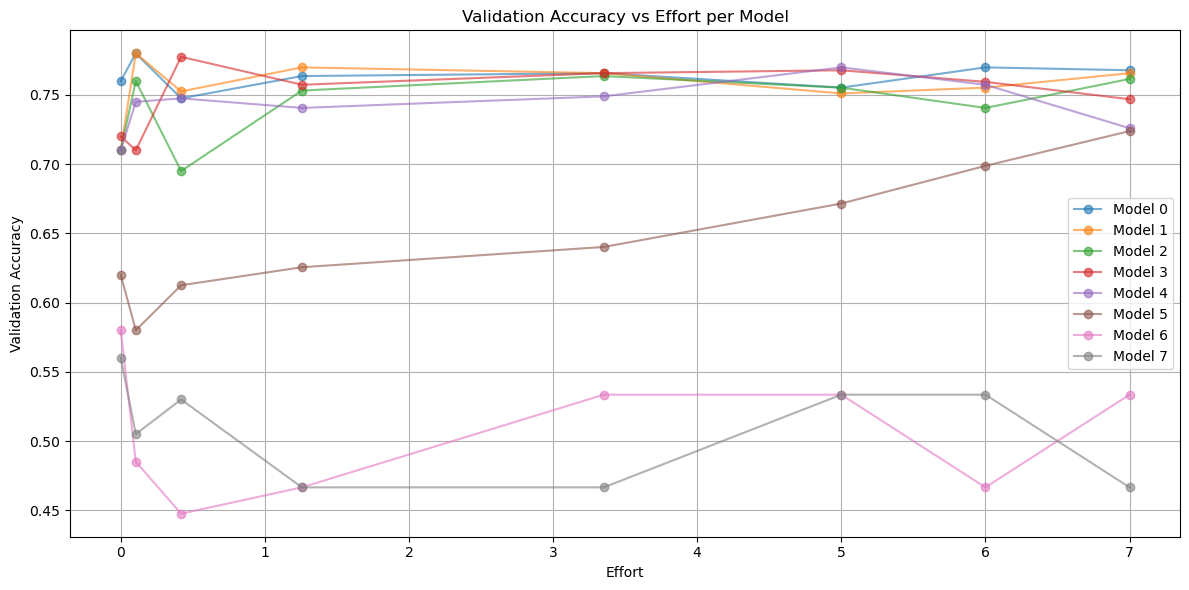

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for idx, row in results_df.iterrows():
    efforts = row["efforts"]
    accs = row["val_acc"]
    plt.plot(efforts, accs, label=f'Model {idx}', marker='o', alpha=0.6)
plt.xlabel("Effort")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Effort per Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
# Train till the end the best model
best_model = generation.get_best_model()

In [13]:
from instance_sampling import create_dataloaders
batch_size = int(results_df.loc[0, 'batch_size']) # batch size for training the model
# For training a model, DataLoader is needed
train_loader = create_dataloaders(X=X_train, y=y_train, 
                       batch_size=batch_size)
val_loader = create_dataloaders(X=X_val, y=y_val, 
                       batch_size=batch_size)
test_loader = create_dataloaders(X=X_test, y=y_test, 
                       batch_size=batch_size)

In [15]:
best_train_loss, best_train_acc, best_val_loss, best_val_acc = best_model.es_train(train_loader=train_loader, val_loader=val_loader,
                    es_patience=50, # epochs without improvement
                    max_epochs=1000, # cap for epochs
                    verbose=True, # print training progress
)

test_loss, test_accuracy = best_model.evaluate(test_loader)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

New best acc found: 0.7866108786610879
Epoch 1: Train Loss=0.4235, Train Acc=0.7920, Val Loss=0.4663, Val Acc=0.7866
Epoch 2: Train Loss=0.4214, Train Acc=0.8041, Val Loss=0.4644, Val Acc=0.7657
Epoch 3: Train Loss=0.4146, Train Acc=0.7983, Val Loss=0.4697, Val Acc=0.7699
Epoch 4: Train Loss=0.4076, Train Acc=0.8151, Val Loss=0.4621, Val Acc=0.7657
Epoch 5: Train Loss=0.3895, Train Acc=0.8182, Val Loss=0.4751, Val Acc=0.7657
Epoch 6: Train Loss=0.3978, Train Acc=0.8119, Val Loss=0.4904, Val Acc=0.7594
Epoch 7: Train Loss=0.3885, Train Acc=0.8156, Val Loss=0.4645, Val Acc=0.7699
Epoch 8: Train Loss=0.3913, Train Acc=0.8240, Val Loss=0.4834, Val Acc=0.7762
Epoch 9: Train Loss=0.3830, Train Acc=0.8188, Val Loss=0.4858, Val Acc=0.7657
Epoch 10: Train Loss=0.3720, Train Acc=0.8387, Val Loss=0.4836, Val Acc=0.7636
Epoch 11: Train Loss=0.3715, Train Acc=0.8334, Val Loss=0.5047, Val Acc=0.7615
Epoch 12: Train Loss=0.3638, Train Acc=0.8298, Val Loss=0.4917, Val Acc=0.7594
Epoch 13: Train Loss=0

In [20]:
results_df.loc[0, 'fcst_accuracy']

np.float64(0.7773859567959827)